In [1]:
import wandb
from collections import defaultdict
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [2]:
api = wandb.Api()
filters = {
    "$and": [
        {"tags": {"$in": ["base"]}},
        {"tags": {"$in": ["event"]}},
    ],
}
runs = api.runs("hughplay/tvr", filters=filters)
runs = sorted(runs, key=lambda run: run.summary["test/acc"])

In [3]:
MODEL_NAMES = {
    # "SingleSubtractCNN": "$CNN$_{-}$-G",
    "SubtractCNN": "$\\text{CNN}_{-}\\text{-G}$",
    # "ConcatCNN": "$\\text{CNN}_{\oplus}\\text{-G}$",
    "BCNN": "$\\text{BCNN-G}$",
    "DUDA": "$\\text{DUDA-G}$",
    # "SingleSubtractResNet": "$ResNet$_{-}$-G",
    "SubtractResNet": "$\\text{ResNet}_{-}\\text{-G}$",
    # "ConcatResNet": "$\\text{ResNet}_{\oplus}\\text{-G}$",
    "SubtractResNetFormer": "$\\text{ResNet}_{-}\\text{-T}$",
    # "ConcatResNetFormer": "$\\text{ResNet}_{\oplus}\\text{-T}$",
}
UNIQUE_MODEL_NAMES = []
for model in MODEL_NAMES.values():
    if model not in UNIQUE_MODEL_NAMES:
        UNIQUE_MODEL_NAMES.append(model)

In [4]:
data = defaultdict(list)
for run in runs:
    for i in range(1, 5):
        metric = f"test/step_{i}/acc"
        model_cls = run.config["model/_target_"].split(".")[-1]
        if model_cls not in MODEL_NAMES:
            continue
        model_name = MODEL_NAMES[model_cls]
        data["model"].append(model_name)
        data["step"].append(f"{i} step" if i == 1 else f"{i} steps")
        data["val"].append(run.summary[metric])
data["model"] = ["$\\text{Human}$"] * 4 + data["model"]
data["step"] = [
    "{} step".format(x) if x == 1 else "{} steps".format(x) for x in range(1, 5)
] + data["step"]
data["val"] = [1.0000, 0.9286, 0.7857, 0.6250] + data["val"]
df = pd.DataFrame(data)


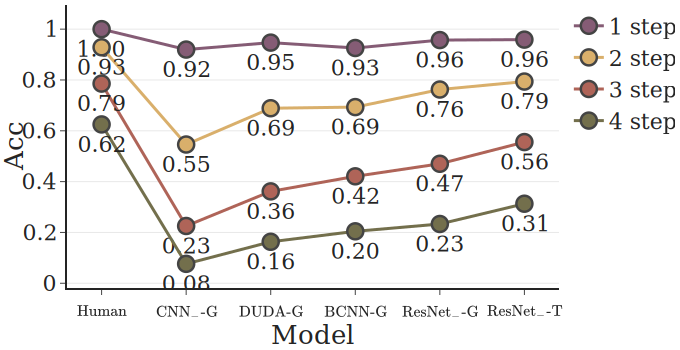

In [6]:
fig = go.Figure()

fig.update_layout(
    font_family="Palatino",
    font_size=22,
    template="simple_white",
    xaxis=dict(title_text="Model"),
    yaxis=dict(title_text="Acc"),
    width=680,
    height=350,
    margin=dict(l=5, r=5, t=5, b=5)
)

# for r, c in zip(df.step.unique(), px.colors.sequential.Aggrnyl[:4][::-1]):
for r, c in zip(df.step.unique(), px.colors.qualitative.Antique):
# for r, c in zip(df.step.unique(), px.colors.sequential.Brwnyl[-4:]):
    if r == 1:
        textposition = 'middle left'
    else:
        textposition = 'bottom'
    plot_df = df[df.step == r]
    fig.add_trace(
        go.Scatter(x=plot_df.model, y=plot_df.val, name=r, text=['{:.2f}'.format(x) for x in plot_df.val], mode='lines+markers+text', textposition='bottom center', line={'width':3, 'color': c}, marker={'size':16}),
#         go.Bar(x=plot_df.model, y=plot_df.val, name=r, marker_color=c, width=0.5),
    )

fig.update_yaxes(showgrid=True, nticks=11, linewidth=2, title_standoff=5)
fig.update_xaxes(linewidth=2, title_standoff=10, tickfont=dict(size=15))
fig.update_traces(marker_line_width=2.5)
fig.write_image("event_results.pdf", engine='kaleido')
fig.show(renderer="svg")